# Importy

In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import warnings

# Ładowanie i przygotowanie danych, wstępna analiza

Mounted at /content/drive
Liczba rekordów w zbiorze treningowym: 59999
Liczba cech w zbiorze treningowym: 784
Liczba rekordów w zbiorze testowym: 9999
Liczba cech w zbiorze testowym: 784
Rozkład kategorii(%):
class
1    11.236854
7    10.441841
3    10.218504
2     9.930166
9     9.915165
0     9.871831
6     9.863498
8     9.751829
4     9.736829
5     9.033484
Name: proportion, dtype: float64


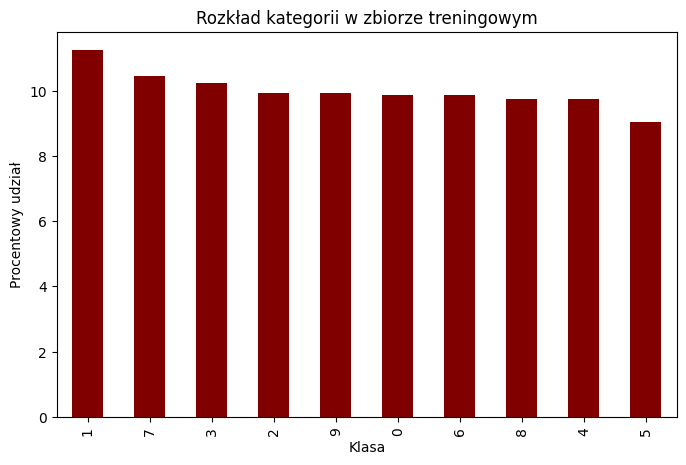

In [2]:
# ładowanie i podział danych
drive.mount('/content/drive')
path = '/content/drive/MyDrive/pro1d/'
mnist_train = pd.read_csv(path + 'mnist_train.csv', header='infer')
mnist_test = pd.read_csv(path + 'mnist_test.csv', header='infer')

# dodanie nazw kolumn
column_names = ['class'] + [f'pixel{i}' for i in range(1, 785)]
mnist_train.columns = column_names
mnist_test.columns = column_names

x_train = mnist_train.drop(columns='class')
y_train = mnist_train['class']

x_test = mnist_test.drop(columns='class')
y_test = mnist_test['class']

# liczba rekordów i cech w zbiorze treningowym i testowym
train_records = mnist_train.shape[0]
train_features = mnist_train.shape[1] - 1

test_records = mnist_test.shape[0]
test_features = mnist_test.shape[1] - 1

print(f"Liczba rekordów w zbiorze treningowym: {train_records}")
print(f"Liczba cech w zbiorze treningowym: {train_features}")
print(f"Liczba rekordów w zbiorze testowym: {test_records}")
print(f"Liczba cech w zbiorze testowym: {test_features}")

# rozkład kategorii(%)
class_distribution = mnist_train['class'].value_counts(normalize=True) * 100
print("Rozkład kategorii(%):")
print(class_distribution)

# wykres słupkowy dla rozkładu kategorii
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='maroon')
plt.title("Rozkład kategorii w zbiorze treningowym")
plt.xlabel("Klasa")
plt.ylabel("Procentowy udział")
plt.show()

warnings.filterwarnings("ignore")

# Analiza głównych składowych PCA

In [3]:
# uzyskanie 90% wyjaśnionej wariancji
# sposób 1
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

pca = PCA(n_components=0.90)
x_train_pca = pca.fit_transform(x_train_scaled)

n_components = x_train_pca.shape[1]

explained_variance = pca.explained_variance_ratio_.sum()

print(f"Liczba komponentów potrzebnych do wyjaśnienia 90% wariancji: {n_components}")
print(f"Procent wyjaśnionej wariancji: {explained_variance:.4f}")

# sposób 2
pca = PCA(n_components=None)
x_train_pca = pca.fit_transform(x_train_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Liczba komponentów potrzebna do wyjaśnienia 90% wariancji: {n_components_90}")


# procent wyjaśnionej wariancji dla liczby komponentów w przedziale od 10 do 150
pca = PCA(n_components=150)
x_train_pca = pca.fit_transform(x_train_scaled)

variance_ratios = []

for n in range(10, 151):
    explained_variance = sum(pca.explained_variance_ratio_[:n])
    variance_ratios.append((n, explained_variance))

# Wyświetlenie wyników
for n, explained_variance in variance_ratios:
    print(f"Liczba komponentów: {n}, Wyjaśniona wariancja: {explained_variance:.4f}")

Liczba komponentów potrzebnych do wyjaśnienia 90% wariancji: 236
Procent wyjaśnionej wariancji: 0.9000
Liczba komponentów potrzebna do wyjaśnienia 90% wariancji: 236
Liczba komponentów: 10, Wyjaśniona wariancja: 0.2767
Liczba komponentów: 11, Wyjaśniona wariancja: 0.2901
Liczba komponentów: 12, Wyjaśniona wariancja: 0.3022
Liczba komponentów: 13, Wyjaśniona wariancja: 0.3133
Liczba komponentów: 14, Wyjaśniona wariancja: 0.3242
Liczba komponentów: 15, Wyjaśniona wariancja: 0.3345
Liczba komponentów: 16, Wyjaśniona wariancja: 0.3444
Liczba komponentów: 17, Wyjaśniona wariancja: 0.3538
Liczba komponentów: 18, Wyjaśniona wariancja: 0.3630
Liczba komponentów: 19, Wyjaśniona wariancja: 0.3719
Liczba komponentów: 20, Wyjaśniona wariancja: 0.3806
Liczba komponentów: 21, Wyjaśniona wariancja: 0.3889
Liczba komponentów: 22, Wyjaśniona wariancja: 0.3970
Liczba komponentów: 23, Wyjaśniona wariancja: 0.4046
Liczba komponentów: 24, Wyjaśniona wariancja: 0.4120
Liczba komponentów: 25, Wyjaśniona wari

# Przekształcenie danych  na nową przestrzeń

In [4]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA(n_components=n_components_90)

x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Wizualizacja danych oryginalnych i skompresowanych

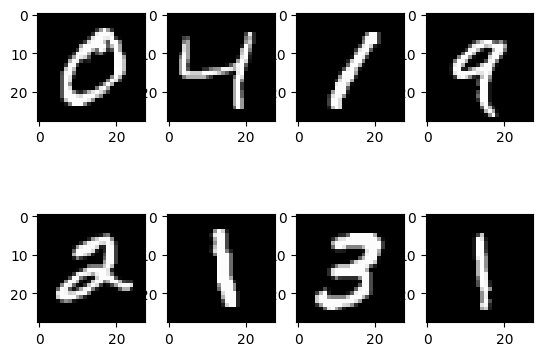

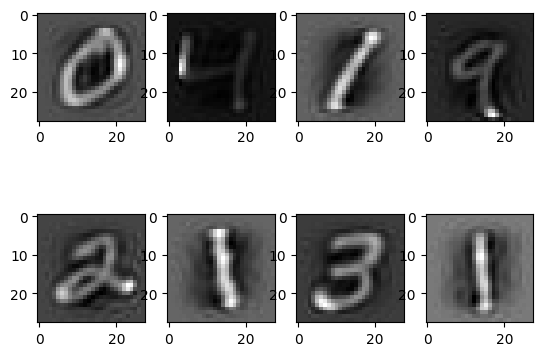

In [10]:
x_recovered_np = pca.inverse_transform(x_train_pca)
x_recovered_pca_df = pd.DataFrame(x_recovered_np)
for i in range(8):
    plt.subplot(240+1+i)
    ith_image = x_train.iloc[i,:]
    ith_image_arr = ith_image.to_numpy()
    ith_image= ith_image_arr.reshape(28,28)
    plt.imshow(ith_image, cmap=plt.get_cmap('gray'))

plt.show()

import numpy as np
for i in range(8):
    plt.subplot(240+1+i)
    ith_image = x_recovered_pca_df.iloc[i,:]
    ith_image_arr = ith_image.to_numpy()
    ith_image= ith_image_arr.reshape(28,28)
    plt.imshow(ith_image, cmap=plt.get_cmap('gray'))

plt.show()


# Trenowanie klasyfikatora DT z optymalizacją parametrów na danych oryginalnych (z wyświetleniem czasu i skuteczności)

In [11]:
max_depths = [10, 15]

best_accuracy = 0
best_max_depth = 0

for max_depth in max_depths:
    dt = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42
        )

    dt.fit(x_train, y_train)

    y_pred = dt.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"max_depth={max_depth}, min_samples_split=5, "
          f"min_samples_leaf=1, accuracy={accuracy:.3%}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_max_depth = max_depth

best_model = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)
start_time = time.time()

best_model.fit(x_train, y_train)

end_time = time.time()
training_time = end_time - start_time

y_pred = best_model.predict(x_test)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Dokładność: {final_accuracy:.3%}")
print(f"\nCzas tworzenia modelu: {training_time:.2f} sekund")

max_depth=10, min_samples_split=5, min_samples_leaf=1, accuracy=86.569%
max_depth=15, min_samples_split=5, min_samples_leaf=1, accuracy=88.229%
Dokładność: 88.229%

Czas tworzenia modelu: 17.01 sekund


# Trenowanie klasyfikatora DT z optymalizacją parametrów na danych skompresowanych (z wyświetleniem czasu i skuteczności)

In [12]:
best_accuracy = 0
best_max_depth = 0

for max_depth in max_depths:
    dt = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42
    )

    dt.fit(x_train_pca, y_train)

    y_pred = dt.predict(x_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"max_depth={max_depth}, min_samples_split=5, "
          f"min_samples_leaf=1, accuracy={accuracy:.3%}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_max_depth = max_depth

variance_ratios = [0.80, 0.85, 0.90, 0.95, 0.99]

results = []

for var_ratio in variance_ratios:
    pca = PCA(n_components=var_ratio)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)

    best_model = DecisionTreeClassifier(
      max_depth=best_max_depth,
      min_samples_split=5,
      min_samples_leaf=1,
      random_state=42
    )

    best_model.fit(x_train_pca, y_train)
    y_pred = best_model.predict(x_test_pca)

    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        "explained_variance_ratio": var_ratio,
        "accuracy": accuracy,
        "n_components": pca.n_components_
    })

best_result = max(results, key=lambda x: x['accuracy'])

pca = PCA(n_components=best_result['n_components'])
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

best_model = DecisionTreeClassifier(
      max_depth=best_max_depth,
      min_samples_split=5,
      min_samples_leaf=1,
      random_state=42
    )

start_time = time.time()

best_model.fit(x_train_pca, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\nCzas treningu: {training_time:.2f} sekund")

y_pred = best_model.predict(x_test_pca)
final_accuracy = accuracy_score(y_test, y_pred)

print(f"Dokładność finalnego modelu na zbiorze testowym: {final_accuracy:.3%}")

max_depth=10, min_samples_split=5, min_samples_leaf=1, accuracy=79.988%
max_depth=15, min_samples_split=5, min_samples_leaf=1, accuracy=83.498%

Czas treningu: 24.97 sekund
Dokładność finalnego modelu na zbiorze testowym: 84.058%


# Trenowanie klasyfikatora  Logistic Regression z optymalizacją parametrów na danych oryginalnych (z wyświetleniem czasu i skuteczności)

In [13]:
best_accuracy = 0
training_time = 0
best_model = log_clf=LogisticRegression(multi_class="multinomial", solver="saga", random_state=42)

for solver in ["saga", "lbfgs"]:
  log_clf=LogisticRegression(multi_class="multinomial", solver=solver, random_state=42)

  start_time = time.time()
  log_clf.fit(x_train, y_train)
  end_time = time.time()

  y_pred = log_clf.predict(x_test)
  test_accuracy = accuracy_score(y_test, y_pred)
  if(test_accuracy > best_accuracy):
    best_accuracy = test_accuracy
    best_model = log_clf
    training_time = end_time - start_time

print(f"Dokładność: {best_accuracy:.3f}")
print(f"Czas tworzenia modelu: {training_time:.3f}s")

Dokładność: 0.926
Czas tworzenia modelu: 236.428s


# Trenowanie klasyfikatora  Logistic Regression z optymalizacją parametrów na danych skompresowanych (z wyświetleniem czasu i skuteczności)

In [14]:
best_accuracy = 0
best_solver=""

for solver in ["saga", "lbfgs"]:
  log_clf=LogisticRegression(multi_class="multinomial", solver=solver, random_state=42)

  start_time = time.time()
  log_clf.fit(x_train_pca, y_train)
  end_time = time.time()

  y_pred = log_clf.predict(x_test_pca)
  test_accuracy = accuracy_score(y_test, y_pred)

  if(test_accuracy > best_accuracy):
     best_solver = solver


variance_ratios = [0.80, 0.85, 0.90, 0.95, 0.99]
results = []

for var_ratio in variance_ratios:
    pca = PCA(n_components=var_ratio)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)

    log_clf=LogisticRegression(multi_class="multinomial", solver=best_solver, random_state=42)

    log_clf.fit(x_train_pca, y_train)
    y_pred = log_clf.predict(x_test_pca)

    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        "explained_variance_ratio": var_ratio,
        "accuracy": accuracy,
        "n_components": pca.n_components_
    })

best_result = max(results, key=lambda x: x['accuracy'])

pca = PCA(n_components=best_result['n_components'])
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

start_time = time.time()
log_clf.fit(x_train_pca, y_train)
end_time = time.time()

training_time = end_time - start_time
y_pred = log_clf.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność: {test_accuracy:.3f}")
print(f"Czas tworzenia modelu: {training_time:.2f}s")
print(f"Najlepsza wariancja PCA: {best_result['explained_variance_ratio']}")


Dokładność: 0.928
Czas tworzenia modelu: 11.95s
Najlepsza wariancja PCA: 0.9


# Trenowanie klasyfikatora  kNN z optymalizacją parametrów na danych oryginalnych i zredukowanych (z wyświetleniem czasu i skuteczności)

In [15]:
# dane oryginalne
n_neighbors_list = [5, 7]

best_accuracy = 0
best_model = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
training_time = 0

for n_neighbors in n_neighbors_list:
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', metric='euclidean')

    start_time = time.time()
    knn_clf.fit(x_train, y_train)
    end_time = time.time()

    y_pred = knn_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = knn_clf
        training_time = end_time-start_time

print(f"Dokładność: {best_accuracy:.3f}")
print(f"Czas tworzenia modelu: {training_time:.2f}s")

Dokładność: 0.970
Czas tworzenia modelu: 0.25s


In [16]:
# na danych zredukowanych
best_accuracy = 0
best_n_neighbors = 0

pca = PCA(n_components=0.9)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

for n_neighbors in n_neighbors_list:
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', metric='euclidean')

    knn_clf.fit(x_train_pca, y_train)

    y_pred = knn_clf.predict(x_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_neighbors = n_neighbors

variance_ratios = [0.80, 0.85, 0.90, 0.95, 0.99]

results = []

for var_ratio in variance_ratios:
    pca = PCA(n_components=var_ratio)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)

    knn_clf = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights='distance', metric='euclidean')
    knn_clf.fit(x_train_pca, y_train)
    y_pred = knn_clf.predict(x_test_pca)

    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        "explained_variance_ratio": var_ratio,
        "accuracy": accuracy,
        "n_components": pca.n_components_
    })

best_result = max(results, key=lambda x: x['accuracy'])

pca = PCA(n_components=best_result['n_components'])
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)


knn_clf = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights='distance', metric='euclidean')

start_time = time.time()
knn_clf.fit(x_train_pca, y_train)
end_time = time.time()

y_pred = knn_clf.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Dokładność: {test_accuracy:.3f}")
print(f"Czas tworzenia modelu: {end_time - start_time:.2f}s")
print(f"Najlepsza wariancja PCA: {best_result['explained_variance_ratio']}")

Dokładność: 0.956
Czas tworzenia modelu: 0.02s
Najlepsza wariancja PCA: 0.8
